## Largely similar to InitialObsPlotting

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

from salishsea_tools import unit_conversions
from salishsea_tools import psu_tools
from cartopy import crs, feature
from shapely.geometry import Point

IOPATH = '/ocean/ghoeven/MOAD/Data/PNW_obs_compiled.csv'

In [2]:
obs = pd.read_csv(IOPATH)
obs['current'] = np.nan

grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')

In [3]:
# Salish Sea cuttoff
x = np.linspace(-130,-122,10)
m = -0.83
b = 48.4-(-124.6)*m

ind = np.where(obs['longitude (degrees_east)'] > (obs['latitude (degrees_north)']-b)/m) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [4]:
# 500m Depth cuttoff
# for the sake of looking at what ACTUALLY gets into the salish sea, can cuttoff at 500 m
# this reasonning is that the CC flows in the top 500, and the CUC core is around 200 m

ind = np.where(obs['depth (m)'] > 500) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)



In [5]:
# Lat and lon cuttoff
xlim, ylim = [-145.5, -120.2], [30, 60]

ind = np.where(obs['latitude (degrees_north)'] > ylim[1]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['latitude (degrees_north)'] < ylim[0]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['longitude (degrees_east)'] > xlim[1]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

ind = np.where(obs['longitude (degrees_east)'] < xlim[0]) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [6]:
# Remove Washington Dept of Ecology and ONC data as they consist of river and salish sea data (not offshore so not relevant)
ind = np.where(obs['source'] == 'department of ecology') 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)
ind = np.where(obs['source'] == 'onc') 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

In [7]:
for s in set(obs.source):
    print(s)
    print(len(obs[obs.source==s]))
    print('\n')

NHL
495859


ios ctd profiles, ios bottle
766


NCEI Coastal
6128


ios mooring
185224


NCEI Salish
464


GEOTRACES
360


CALCOFI
196413


ooi
50567


ios mooring, ios bottle
9


NCEI Coastal, NHL
10


NCEI PNW
977


ios bottle
152728


OCNMS
46231


ios bottle, NCEI PNW
406


ios bottle, GEOTRACES
179


ios ctd profiles
62649


ios bottle, NCEI PNW, GEOTRACES
3




/tmp/ipykernel_3544224/1612283528.py:18: RuntimeWarning: invalid value encountered in sqrt
  x = np.sqrt((1-((y-42)**2)/(9**2))*(6**2))-130.8
/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/shapely/creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)


Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #471 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

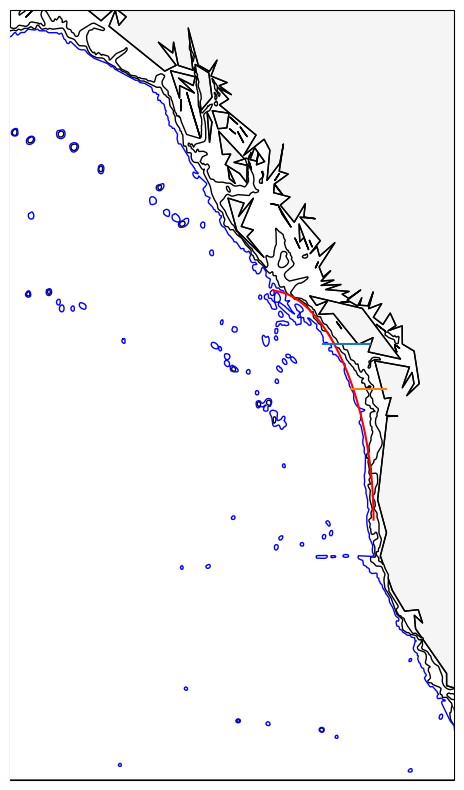

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='b',zorder=4))


# offshore cuttoff 
y=np.linspace(42,52,100)
x = np.sqrt((1-((y-42)**2)/(9**2))*(6**2))-130.8
ax.plot(x,y, transform=crs.PlateCarree(),zorder=7, c='r')

#north cuttoff
ax.plot([-127.7,-125],[49,49], transform=crs.PlateCarree(),zorder=7)

# south cuttoff
ax.plot([-126.1,-124.1],[47.3,47.3], transform=crs.PlateCarree(),zorder=7)
# south deep s>=33.9
# south shelf s>=32 <33.9
# south fresh s<32

In [9]:
# filter those offshore of the 2000 m isobar

# Load the bathymetry shapefile
bathymetry = gpd.read_file("/ocean/ghoeven/MOAD/Data/ne_10m_bathymetry_I_2000.shp")

# Filter for the 2000 m contour polygons
contour_2000m = bathymetry[bathymetry['depth'] == 2000]

contour_2000m = contour_2000m.set_crs('EPSG:4326')

# Now, ensure both GeoDataFrames are in the same CRS
obs['geometry'] = obs.apply(lambda row: Point(row["longitude (degrees_east)"], row["latitude (degrees_north)"]), axis=1)
obs_gdf = gpd.GeoDataFrame(obs, geometry='geometry', crs='EPSG:4326')  # Ensure the CRS matches bathymetry
obs_gdf = obs_gdf.to_crs(contour_2000m.crs)  # Make sure your observations match the bathymetry CRS

# Perform the spatial join or classification as before
obs_gdf['is_shelf'] = obs_gdf.within(contour_2000m.geometry.union_all())

# Apply classification based on the result of spatial join
obs_gdf['location_type'] = obs_gdf['is_shelf'].apply(lambda x: 'offshore' if x else 'shelf')

In [10]:
# can we do the same for data between the 2000m and 200m isobar? call it "slope" data instead of "shelf"

# Load the bathymetry shapefile
bathymetry = gpd.read_file("/ocean/ghoeven/MOAD/Data/ne_10m_bathymetry_K_200.shp")

# Filter for the 2000 m contour polygons
contour_200m = bathymetry[bathymetry['depth'] == 200]

contour_200m = contour_200m.set_crs('EPSG:4326')

# Now, ensure both GeoDataFrames are in the same CRS
obs_200 = obs_gdf[obs_gdf.location_type=='shelf'] # using the shelf data only so that we don't group the offshore data in with the slope data
# obs_200 = obs_200.to_crs(contour_200m.crs)  # Make sure your observations match the bathymetry CRS

# Perform the spatial join or classification as before
obs_200['is_slope'] = obs_200.within(contour_200m.geometry.union_all())

# Apply classification based on the result of spatial join
obs_200['location_type'] = obs_200['is_slope'].apply(lambda x: 'slope' if x else 'shelf')

/home/rbeutel/anaconda3/envs/synthesis/lib/python3.13/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [11]:
obs['location'] = obs_gdf['location_type']
obs.location[obs.location=='shelf'] = obs_200['location_type']

/tmp/ipykernel_3544224/3885089491.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  obs.location[obs.location=='shelf'] = obs_200['location_type']
/tmp/ipykernel_3544224/3885089491.py:2: SettingWithCopyWarning: 
A value is trying to be set

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #491 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

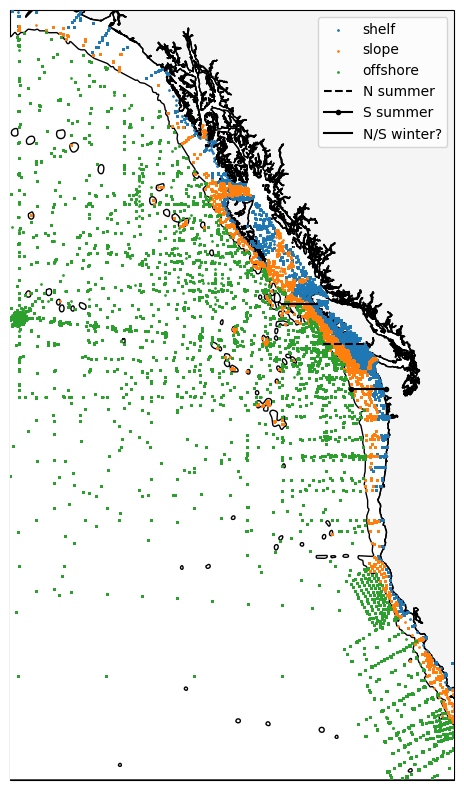

In [12]:
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

# points
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'shelf'],obs['latitude (degrees_north)'][obs.location == 'shelf'], transform=crs.PlateCarree(),s=1,zorder=5,label='shelf')
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'slope'],obs['latitude (degrees_north)'][obs.location == 'slope'], transform=crs.PlateCarree(),s=1,zorder=5,label='slope')
ax.scatter(obs['longitude (degrees_east)'][obs.location == 'offshore'],obs['latitude (degrees_north)'][obs.location == 'offshore'], transform=crs.PlateCarree(),s=1,zorder=5,label='offshore')

#cuttoffs
ax.plot([-127.7,-125],[49,49], 'k--', transform=crs.PlateCarree(),zorder=7,label='N summer')
ax.plot([-126.1,-124.1],[47.3,47.3], 'k.-', transform=crs.PlateCarree(),zorder=7,label='S summer')
ax.plot([-130,-128],[50.5,50.5], 'k', transform=crs.PlateCarree(),zorder=7,label='N/S winter?')


ax.legend()

In [13]:
# we're going to divide our watermasses differently during upwelling and downwelling
# so get month from the time

obs['time']=pd.to_datetime(obs.time)
obs['month'] = [obs.time[i].month for i in obs.index]

In [14]:
# Seperating Shelf current 
obs['current'] = ""

# Adding all points on the shelf to our overall shelf current
obs['current'][obs['location']== 'shelf'] = 'Shelf_Current'
# Removing shelf current rows that do not fulfill our minimum salinity requirements (river water)
obs = obs[~((obs['current'] == 'Shelf_Current') & (obs['salinity (g kg-1)'] < 31.5))]

/tmp/ipykernel_3544224/4205603307.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  obs['current'][obs['location']== 'shelf'] = 'Shelf_Current'
/tmp/ipykernel_3544224/4205603307.py:5: SettingWithCopyWarning: 
A value is trying to be set on

In [15]:
# Seperating CUC
densMin = 26.5
densMax = 26.6
depthMin = 175
depthMax = 275
obs['salinity (psu)'] = unit_conversions.teos_psu(obs['salinity (g kg-1)'])
obs['density (kg m-3)'] = psu_tools.calculate_density(obs['temperature (degC)'], obs['salinity (psu)'])-1000

# Selecting data that is on the 26.5-26.6 isopycnal and where a current is over the continental slope
mask = ((obs['density (kg m-3)'] >= densMin) 
        & (obs['density (kg m-3)'] <= densMax)
        & (obs['depth (m)'] <= depthMax)
        & (obs['depth (m)'] >= depthMin)
        & (obs['latitude (degrees_north)'] < 50.1)
        & (obs['location'] == 'slope'))
obs.loc[mask, 'current'] = 'CUC'
print(obs[mask][['depth (m)', 'density (kg m-3)', 'location']].head())
cuc_obs = obs[obs['current'] == 'CUC']
print(cuc_obs[~(cuc_obs['location'] == 'slope')])

       depth (m)  density (kg m-3) location
85990      175.0         26.568594    slope
85991      176.0         26.576781    slope
85992      181.0         26.578257    slope
85993      182.0         26.594285    slope
85994      183.0         26.594309    slope
Empty DataFrame
Columns: [Unnamed: 0, time, longitude (degrees_east), latitude (degrees_north), depth (m), pressure (dbar), temperature (degC), salinity (g kg-1), DO (umol kg-1), NO3 (uM), NO2 (uM), NH4 (uM), PO4 (uM), SiO4 (uM), Chl (mg m-3), TA (uM), DIC (uM), Carbonate, Aragonite, Calcite, Cd (nmol kg-1), Co (nmol kg-1), Cu (nmol kg-1), Fe (nmol kg-1), Mn (nmol kg-1), Ni (nmol kg-1), Zn (nmol kg-1), source, Nstar (umol kg-1), spice, current, geometry, location, month, salinity (psu), density (kg m-3)]
Index: []

[0 rows x 36 columns]


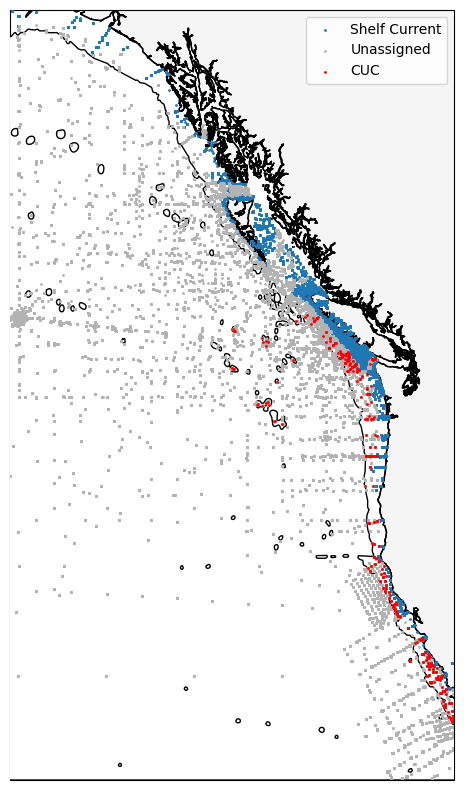

In [16]:
xlim, ylim = [-145.5, -120.2], [30, 60]

fig, ax = plt.subplots(1,1, figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

# Make plot area
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', zorder=4))

# and bathymetry..?
ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

# points
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'Shelf_Current'],obs['latitude (degrees_north)'][obs.current == 'Shelf_Current'], transform=crs.PlateCarree(),s=1,zorder=5,label='Shelf Current')
ax.scatter(obs['longitude (degrees_east)'][obs.current == ''],obs['latitude (degrees_north)'][obs.current == ''], c='0.7', transform=crs.PlateCarree(),s=1,zorder=5,label='Unassigned')
ax.scatter(obs['longitude (degrees_east)'][obs.current == 'CUC'],obs['latitude (degrees_north)'][obs.current == 'CUC'], c='r', transform=crs.PlateCarree(),s=1,zorder=5,label='CUC')


#cuttoffs
# ax.plot([-127.7,-125],[49,49], 'k--', transform=crs.PlateCarree(),zorder=7,label='N summer')
# ax.plot([-126.1,-124.1],[47.3,47.3], 'k.-', transform=crs.PlateCarree(),zorder=7,label='S summer')
# ax.plot([-130,-128],[50.5,50.5], 'k', transform=crs.PlateCarree(),zorder=7,label='N/S winter?')


ax.legend()

Text(0, 0.5, 'depth (m)')

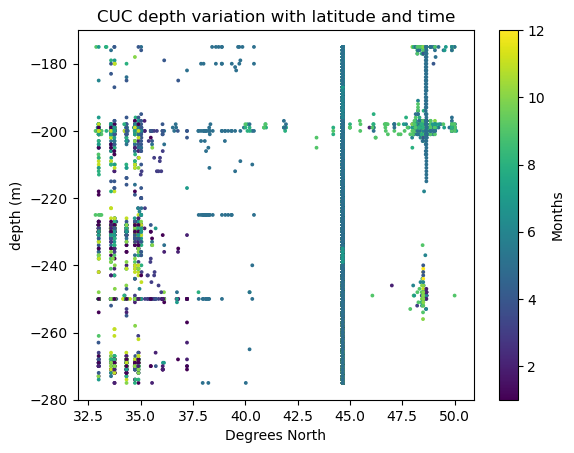

In [17]:
obs_cuc = obs[obs["current"] == 'CUC']

sc = plt.scatter(obs_cuc['latitude (degrees_north)'], -obs_cuc['depth (m)'], c=obs_cuc['month'], cmap='viridis', s=3, vmin=1, vmax=12)
plt.colorbar(sc, orientation='vertical', label='Months')
plt.title('CUC depth variation with latitude and time')
plt.xlabel('Degrees North')
plt.ylabel('depth (m)')
# sc = ax.scatter(lon0m, lat0m, transform=crs.PlateCarree(), c=chl0m, cmap='viridis', s=3, vmin=0, vmax=45)
# cbar = fig.colorbar(sc, ax=ax, orientation='vertical', label='Chlorophyll at Surface (mg m^-3)')

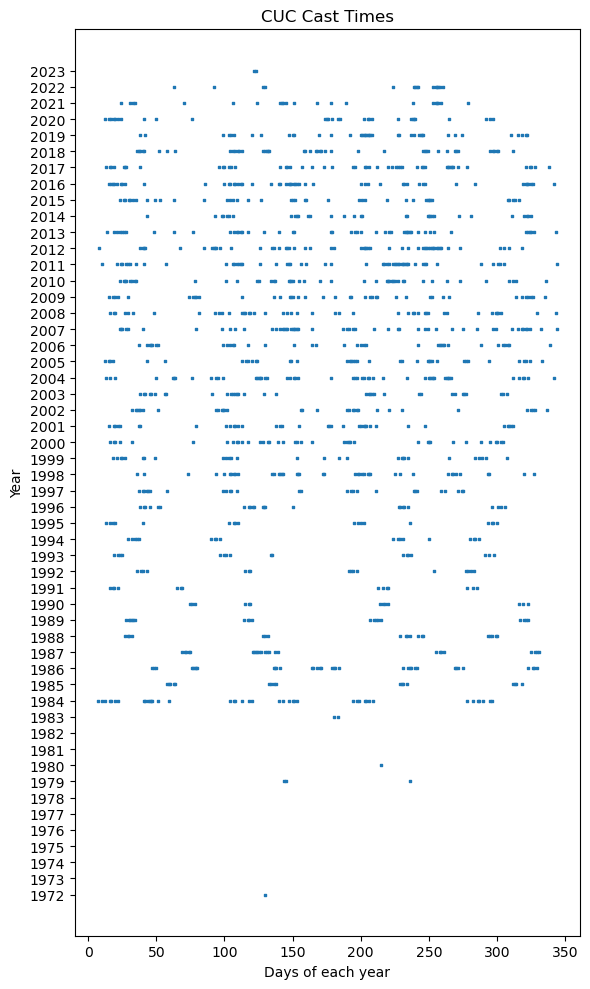

In [18]:
# plt.scatter(obs_cuc['time'], np.ones(len(obs_cuc)))

fig, ax = plt.subplots(figsize=(6, 10))

obs_cuc_dd = obs_cuc.drop_duplicates(subset='time', keep='first')

yearDay = obs_cuc_dd['time'].dt.dayofyear
year = obs_cuc_dd['time'].dt.year

ax.scatter(yearDay, year, s=2, marker='s' )
# ax.scatter(yearDay, year, s=2, marker='s', c=obs_cuc['month'], cmap='viridis')

ax.set_title('CUC Cast Times')
ax.set_yticks(range(1972, 2024))  
ax.set_ylabel('Year')
ax.set_xlabel('Days of each year')


plt.tight_layout()
plt.show()